## Do you know ~~what~~ *who* you’re drinking?
#### TornADA project - CS-401 Fall 2023

### 0. Introduction

This notebook contains our data handling pipeline with loading and cleaning, initial overall analysis of dataset and first approach to answer the research question. 

For now only data from RateBeer website is used in this notebook. It is because we didn't choose match_beer dataset as many breweries owned by big companies (our main subject of study) are missing there due to differences in spelling. We're currently not able to handle analysis of two datasets RB and BA in parallel because of technical difficulties (kernel crash occurred) and problems with additional dataset(details below). However, because of similarity of the structure, only changing the source of the data with some minor corrections should be enough to repeat analysis on BeerAdvocate dataset when the dataset will became available. 

Creating additional dataset, which will match breweries across the years is a way more time consuming then we assume. Because of that we don't manage to create a mapping dataset for all big companies that we want to analyze. We believe that doing it in the right way is very important to make our study valuable. For now, we created very detailed history of acquisitions and sales for AB InBev, the biggest beer company in the world, which control about 25% of beer market in 2022, and based our analyze in that notebook on that mapping, which already lead to interesting result. Mapping datasets for remaining companies should be completed by the following week. Because the creation of dataset has to be done partially separately for two websites, we are now focused on completion this task for RB dataset, but we are planning to do it for BA dataset as well.

In [3]:
import pandas as pd
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

### 1. Loading data

In [4]:
# load data from csv file to dataframes
RB_breweries = pd.read_csv('./data/RateBeer/breweries.csv')
RB_beers = pd.read_csv('./data/RateBeer/beers.csv')
RB_users = pd.read_csv('./data/RateBeer/users.csv')
RB_Inbev_group = pd.read_csv('./data/inbev.csv')

# parse the ratings file to dataframe without textual description
RB_ratings = helpers.parse_reviews('./data/RateBeer/ratings.txt','./data/RateBeer')

In [5]:
# convert joined column to datetime
RB_users['joined'] = pd.to_datetime(RB_users['joined'], unit='s')

# reorganize InBev dataframe so now each row is in 'relational database format'
# each row contains data about one brewery in one year 
RB_Inbev_group = RB_Inbev_group.melt(var_name='year', value_name='brewery_name').dropna()
RB_Inbev_group = RB_Inbev_group.astype({'year': 'int'})
RB_Inbev_group['group'] = 'AB InBev'


Display obtained dataframes

In [6]:
RB_breweries.head()

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


In [7]:
RB_beers.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN


In [8]:
RB_users.head()

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,2012-05-20 10:00:00,Poland
1,89,442761,MAGICuenca91,2017-01-10 11:00:00,Spain
2,169,288889,Sibarh,2013-11-16 11:00:00,Poland
3,3371,250510,fombe89,2013-03-22 11:00:00,Spain
4,13043,122778,kevnic2008,2011-02-02 11:00:00,Germany


In [9]:
RB_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Slumbrew Sittin on Hop of the World,220923,Somerville Brewing Company &#40;Slumbrew&#41;,13696,India Pale Ale (IPA),6.8,2015-11-14 11:00:00,corby112,55936,4,6,3,5,10,2.8
1,Slumbrew Sittin on Hop of the World,220923,Somerville Brewing Company &#40;Slumbrew&#41;,13696,India Pale Ale (IPA),6.8,2014-04-29 10:00:00,mkgrenwel,22108,3,6,3,5,14,3.1
2,Slumbrew Sittin on Hop of the World,220923,Somerville Brewing Company &#40;Slumbrew&#41;,13696,India Pale Ale (IPA),6.8,2013-12-08 11:00:00,ben4321,87939,3,7,4,7,15,3.6
3,Slumbrew Sittin on Hop of the World,220923,Somerville Brewing Company &#40;Slumbrew&#41;,13696,India Pale Ale (IPA),6.8,2013-10-23 10:00:00,Tejas,14068,3,4,3,6,14,3.0
4,Slumbrew Sittin on Hop of the World,220923,Somerville Brewing Company &#40;Slumbrew&#41;,13696,India Pale Ale (IPA),6.8,2013-10-09 10:00:00,TaktikMTL,6173,2,7,4,8,15,3.6


In [10]:
RB_Inbev_group.head()

,year,brewery_name,group
0,2000,AB InBev UK,AB InBev
1,2000,Arcense Bierbrouwerij (AB-InBev),AB InBev
2,2000,Belle-Vue (InBev),AB InBev
3,2000,Bergenbier SA (MolsonCoors),AB InBev
4,2000,Borsodi Sörgyár (MolsonCoors),AB InBev


### 2. Sanity Check

Check how many NaN values are present in every column and try to deal with them

#### a) Breweries

In [11]:
print(RB_breweries.isna().mean())

id           0.0
location     0.0
name         0.0
nbr_beers    0.0
dtype: float64


#### b) Users

In [12]:
print(RB_users.isna().mean())

nbr_ratings    0.000000
user_id        0.000000
user_name      0.000000
joined         0.000428
location       0.279049
dtype: float64


We want to check if missing data about location are equally distributed across all the years.

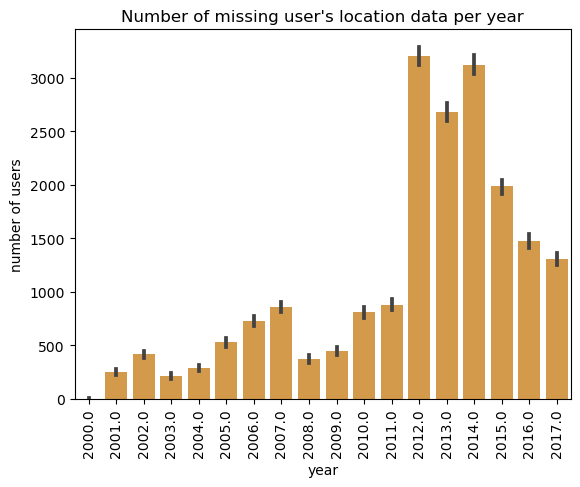

In [13]:
missing_location_by_joined_year = RB_users.loc[:, ['joined', 'location']]
missing_location_by_joined_year['location'] = pd.isna(missing_location_by_joined_year['location']).astype('int')
missing_location_by_joined_year['joined'] = missing_location_by_joined_year['joined'].dt.year
sns.barplot(missing_location_by_joined_year, y='location', x='joined', estimator='sum', color='#eb9e34')
plt.title("Number of missing user's location data per year")
plt.xlabel('year')
plt.ylabel('number of users')
plt.xticks(rotation=90)
plt.show()

We noticed that after 2012 there are more missing location that before.

In [14]:
# drop the value without joined time - as there are only 0.04 % of such user
RB_users_validated = RB_users.dropna(subset='joined').copy()

# change Nan values to undefined label - as removing them from dataset will result in big information loss
RB_users_validated = RB_users_validated.fillna('Undefined')

#### c) Beers

In [15]:
print(RB_beers.isna().mean())

beer_id                      0.000000
beer_name                    0.000000
brewery_id                   0.000000
brewery_name                 0.000000
style                        0.000000
nbr_ratings                  0.000000
overall_score                0.764686
style_score                  0.764595
avg                          0.105012
abv                          0.095218
avg_computed                 0.102676
zscore                       0.904479
nbr_matched_valid_ratings    0.000000
avg_matched_valid_ratings    0.904479
dtype: float64


Many values are missing in overall_score and style_score column. In fact, that scores are only calculated for beers that have more than 10 ratings. We decided to check how many ratings are connected with beers with and without overall_score defined. 

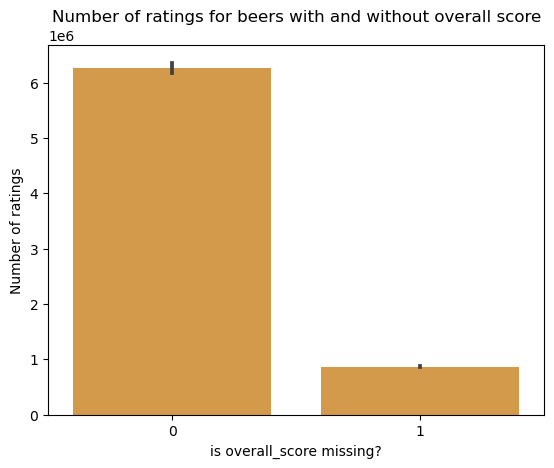

In [97]:
sns.barplot(RB_beers, estimator='sum', x=pd.isna(RB_beers['overall_score']).astype('int'), y='nbr_ratings', color='#eb9e34')
plt.xlabel("is overall_score missing?")
plt.ylabel('Number of ratings')
plt.title('Number of ratings for beers with and without overall score')
plt.show()

Although there are less then 25% of beers with defined overall_score in dataset, there are much more ratings concerning them as there are the most popular. Because of that fact we decided not to remove that values but encode missing values with -1. 

In [17]:
# removing columns with more than 90% of missing values
RB_beers_validated = RB_beers.drop(['zscore', 'avg_matched_valid_ratings'], axis=1).copy()

# removing beers that have 0 reviews
RB_beers_validated = RB_beers_validated[RB_beers_validated['nbr_ratings'] > 0]

print(RB_beers_validated.isna().mean())

beer_id                      0.000000
beer_name                    0.000000
brewery_id                   0.000000
brewery_name                 0.000000
style                        0.000000
nbr_ratings                  0.000000
overall_score                0.737760
style_score                  0.737659
avg                          0.002629
abv                          0.092596
avg_computed                 0.000000
nbr_matched_valid_ratings    0.000000
dtype: float64


In [18]:
# dropping beers with NaN values in columns 'avg', 'abv', 'avg_computes' as there are less than 10% of them
RB_beers_validated = RB_beers_validated.dropna(subset=['avg', 'abv', 'avg_computed'])

# encode remaining Nans in overall_score and style_score with 
RB_beers_validated = RB_beers_validated.fillna(-1)

#### d) Ratings

In [19]:
print(RB_ratings.isna().mean())

beer_name       0.000000
beer_id         0.000000
brewery_name    0.000000
brewery_id      0.000000
style           0.000000
abv             0.024569
date            0.000000
user_name       0.000000
user_id         0.000000
appearance      0.000000
aroma           0.000000
palate          0.000000
taste           0.000000
overall         0.000000
rating          0.000000
dtype: float64


In [20]:
# dropping row with missing values as there are only ~2.5% of them
RB_ratings_validated = RB_ratings.dropna().copy()

#### e) Groups

In [21]:
print(RB_Inbev_group.isna().mean())

year            0.0
brewery_name    0.0
group           0.0
dtype: float64


### 3. Dataframe merging

In [22]:
# merge beers df with location of brewery that brewed it
RB_beers_with_brewery_location = RB_beers_validated.merge(RB_breweries[['location', 'id']], left_on='brewery_id', right_on='id', how='left')

# print columns of resulting df with percentage of missing values in each
print(RB_beers_with_brewery_location.isna().mean())

beer_id                      0.0
beer_name                    0.0
brewery_id                   0.0
brewery_name                 0.0
style                        0.0
nbr_ratings                  0.0
overall_score                0.0
style_score                  0.0
avg                          0.0
abv                          0.0
avg_computed                 0.0
nbr_matched_valid_ratings    0.0
location                     0.0
id                           0.0
dtype: float64


In [23]:
# merge ratings df with group that produced rated beer (currently only AB InBev) based on brewery name and year of review
RB_ratings_with_groups = RB_ratings_validated.merge(RB_Inbev_group,
                                                    left_on=['brewery_name', RB_ratings_validated['date'].apply(lambda x: x.year)],
                                                    right_on=['brewery_name', 'year'],
                                                    how='left')

# replace name of group for other beers
RB_ratings_with_groups = RB_ratings_with_groups.fillna('Other')

# print columns of resulting df with percentage of missing values in each
print(RB_ratings_with_groups.isna().mean())

beer_name       0.0
beer_id         0.0
brewery_name    0.0
brewery_id      0.0
style           0.0
abv             0.0
date            0.0
user_name       0.0
user_id         0.0
appearance      0.0
aroma           0.0
palate          0.0
taste           0.0
overall         0.0
rating          0.0
year            0.0
group           0.0
dtype: float64


In [24]:
# merge ratings_group df with information about users
RB_ratings_with_groups_and_users = RB_ratings_with_groups.merge(RB_users_validated[['joined', 'location', 'nbr_ratings', 'user_id']], on='user_id')
RB_ratings_with_groups_and_users = RB_ratings_with_groups_and_users.rename(columns={
    'nbr_ratings': 'total_user_nbr_ratings',
    'location': 'user_location',
    'joined': 'user_joined'
    })

# print columns of resulting df with percentage of missing values in each
print(RB_ratings_with_groups_and_users.isna().mean())

beer_name                 0.0
beer_id                   0.0
brewery_name              0.0
brewery_id                0.0
style                     0.0
abv                       0.0
date                      0.0
user_name                 0.0
user_id                   0.0
appearance                0.0
aroma                     0.0
palate                    0.0
taste                     0.0
overall                   0.0
rating                    0.0
year                      0.0
group                     0.0
user_joined               0.0
user_location             0.0
total_user_nbr_ratings    0.0
dtype: float64


In [25]:
# inner merge breweries with groups that own it
# equivalent to selecting only InBev breweries from dataset
RB_group_breweries = RB_breweries.merge(RB_Inbev_group, left_on='name', right_on='brewery_name') 

In [26]:
# crash kernel

# RB_ratings_full_data = RB_ratings_with_groups_and_users.merge(RB_beers_with_brewery_location[['location', 'brewery_id']], on='brewery_id')
# RB_ratings_full_data = RB_ratings_full_data.rename(columns={
#     'location': 'brewery_location',
#     })

# print(RB_ratings_with_groups_and_users.isna().mean())

### 4. Datasets exploration

#### a. Breweries

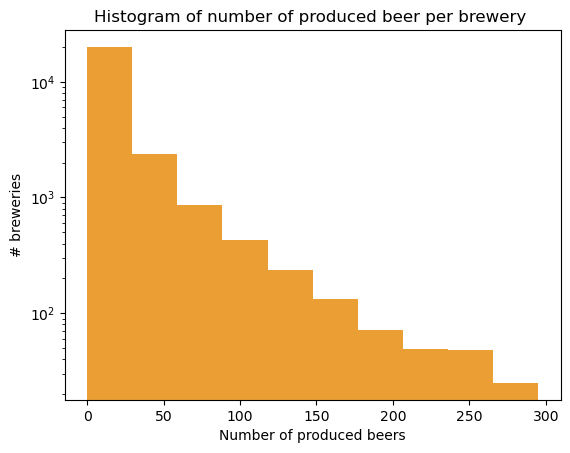

In [27]:
plt.hist(x=RB_breweries['nbr_beers'], color='#eb9e34')
plt.yscale('log')
plt.title('Histogram of number of produced beer per brewery ')
plt.xlabel('Number of produced beers')
plt.ylabel('# breweries')
plt.show()

To obtain reasonable plot we have to set log-scale on y-axis. The distribution in heavily right skewed, follow a power law. It means that there are many breweries that produce only few kind of beers and there are some that produce a lot.   

In [28]:
# print top 10 locations based on number of breweries
RB_breweries.groupby('location')['id'].count().sort_values(ascending=False).head(10)

location
England                      2124
Germany                      1999
Italy                        1051
Canada                        884
United States, California     867
France                        843
Spain                         780
Australia                     550
Switzerland                   534
Netherlands                   525
Name: id, dtype: int64

In [29]:
# print top 10 locations based on number of produced beers
RB_breweries.groupby('location')['nbr_beers'].sum().sort_values(ascending=False).head(10)

location
England                        49206
United States, California      28535
Canada                         24923
Germany                        21498
United States, Colorado        15227
United States, Washington      11395
United States, Michigan        11349
United States, New York        11295
United States, Pennsylvania    10967
United States, Illinois        10541
Name: nbr_beers, dtype: int64

It seems interesting that in some states there are so many different beers types, despite they are not in the top 10 based on number of breweries 

In [30]:
print(scipy.stats.pearsonr(RB_breweries.groupby('location')['nbr_beers'].sum(), RB_breweries.groupby('location')['id'].count()))

PearsonRResult(statistic=0.8739448602431515, pvalue=5.157898176146341e-85)


But still the correlation between number of breweries and number of different beer types produced are strong, which seems very intuitive 

#### b. Beers

In [31]:
RB_beers_with_brewery_location.describe()

,beer_id,brewery_id,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,nbr_matched_valid_ratings,id
count,359014.000000,359014.000000,359014.000000,359014.000000,359014.000000,359014.000000,359014.000000,359014.000000,359014.00000,359014.000000
mean,275194.755447,11935.444231,19.347583,14.872114,14.662907,3.036124,6.059733,3.249787,2.84253,11935.444231
std,153130.241976,8418.728135,89.489186,29.615487,29.372092,0.305866,1.928962,0.500016,29.51518,8418.728135
min,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,0.010000,0.500000,0.00000,1.000000
25%,145407.250000,3732.000000,1.000000,-1.000000,-1.000000,2.880000,4.800000,3.000000,0.00000,3732.000000
50%,280536.500000,12142.000000,4.000000,-1.000000,-1.000000,3.040000,5.500000,3.307895,0.00000,12142.000000
75%,407977.750000,18261.000000,11.000000,16.000000,16.000000,3.190000,7.000000,3.600000,0.00000,18261.000000
max,536489.000000,32246.000000,5272.000000,100.000000,100.000000,4.520000,73.000000,5.000000,5270.00000,32246.000000


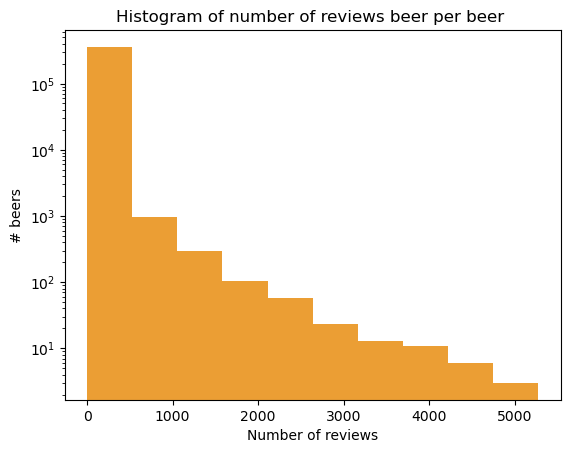

In [32]:
plt.hist(RB_beers_with_brewery_location['nbr_ratings'], color='#eb9e34')
plt.yscale('log')
plt.title('Histogram of number of ratings beer per beer ')
plt.xlabel('Number of ratings')
plt.ylabel('# beers')
plt.show()

Distribution of number of ratings per beer is also right skewed and must be ploted on chart with log y-axis. There are many beers with only few ratings and some beers with huge number of it (up to 50000)  

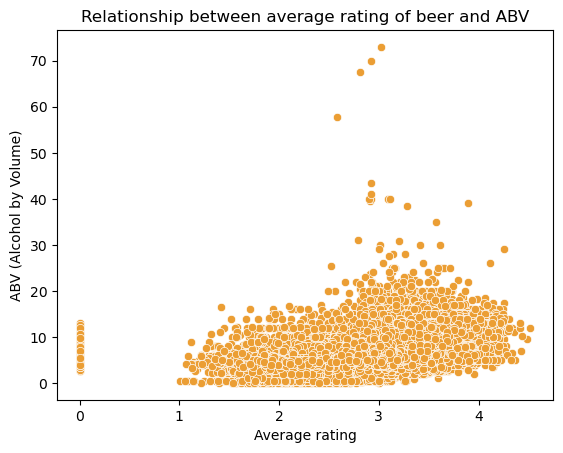

In [71]:
# plot the relationship between ABV and average rating for all beers
sns.scatterplot(RB_beers_with_brewery_location, x='avg', y='abv', color='#eb9e34')
plt.title('Relationship between average rating of beer and ABV')
plt.xlabel('Average rating')
plt.ylabel('ABV (Alcohol by Volume)')
plt.show()

In [34]:
scipy.stats.pearsonr(RB_beers_with_brewery_location['abv'], RB_beers_with_brewery_location['avg'])

PearsonRResult(statistic=0.35821352250356775, pvalue=0.0)

The correlation between ABV and rating of the beer is positive but weak. It is visible also in the scatterplot.

#### c. Users

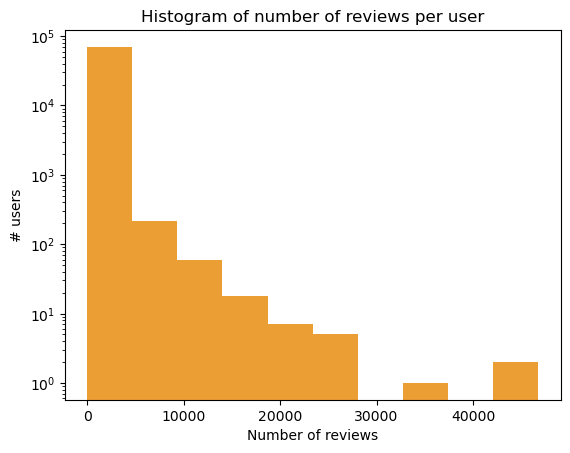

In [35]:
plt.hist(x=RB_users['nbr_ratings'], color='#eb9e34')
plt.yscale('log')
plt.title('Histogram of number of reviews per user')
plt.xlabel('Number of reviews')
plt.ylabel('# users')
plt.yscale('log')

In [36]:
# users by location
print(RB_users_validated.groupby('location')['user_id'].count().sort_values(ascending=False).head(10), '\n\n')
users_from_USA = len(RB_users_validated[RB_users_validated['location'].str.contains('United States')])


location
Undefined                      19552
Canada                          3255
United States, California       2804
England                         2734
Poland                          1701
United States, Pennsylvania     1632
Australia                       1476
United States, Texas            1423
United States, Illinois         1406
United States, New York         1352
Name: user_id, dtype: int64 




In [37]:
print(f'Users from USA combined: {users_from_USA}')
print(f'Fraction of users from USA combined: {users_from_USA/len(RB_users_validated)}')

Users from USA combined: 26855
Fraction of users from USA combined: 0.38285526916058393


In [38]:
print(RB_users_validated.groupby('location')['nbr_ratings'].sum().sort_values(ascending=False).head(10), '\n\n')
nbr_ratings_from_USA = RB_users_validated[RB_users_validated['location'].str.contains('United States')]['nbr_ratings'].sum()

location
Denmark                        633814
Canada                         546493
England                        465714
United States, California      333597
Sweden                         305113
Netherlands                    263071
Germany                        238709
United States, Pennsylvania    233740
Norway                         231676
Undefined                      217860
Name: nbr_ratings, dtype: int64 


Number of ratings posted by users from USA combined: 3274619
Fraction of ratings posted by users from USA combined: 0.4289776058116133


In [72]:
print(f'Number of ratings posted by users from USA combined: {nbr_ratings_from_USA}')
print(f"Fraction of ratings posted by users from USA combined: {nbr_ratings_from_USA/RB_users_validated['nbr_ratings'].sum()}")

Number of ratings posted by users from USA combined: 3274619
Fraction of ratings posted by users from USA combined: 0.4289776058116133


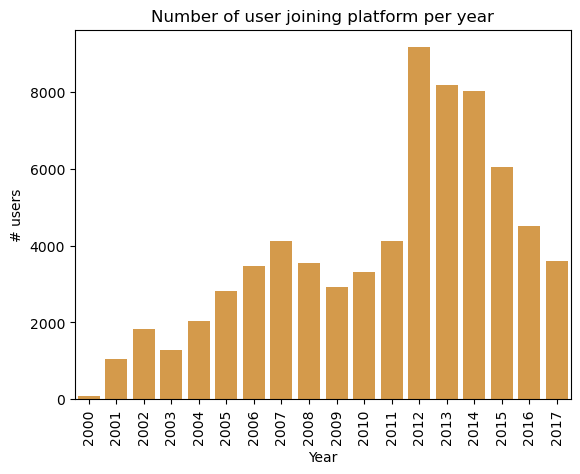

In [96]:
sns.countplot(RB_users_validated, x=RB_users_validated['joined'].dt.year, color='#eb9e34')
plt.title('Number of user joining platform per year')
plt.xlabel('Year')
plt.ylabel('# users')
plt.xticks(rotation=90)
plt.show()

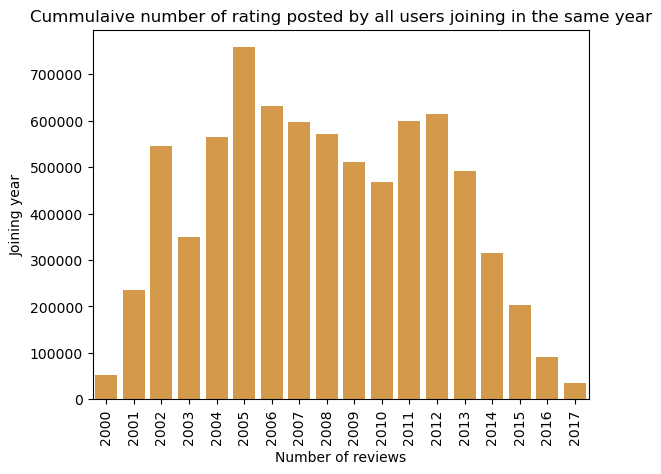

In [40]:
number_of_revievs_by_join_year = RB_users_validated.groupby(RB_users_validated['joined'].dt.year)['nbr_ratings'].sum()
sns.barplot(x=number_of_revievs_by_join_year.index, y=number_of_revievs_by_join_year.values, color='#eb9e34')
plt.title('Cummulaive number of rating posted by all users joining in the same year')
plt.xlabel('Number of reviews')
plt.ylabel('Joining year')
plt.xticks(rotation=90)
plt.show()

#### d. Ratings

In [125]:
RB_ratings_with_groups_and_users.describe()

,beer_id,brewery_id,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,year,user_joined,total_user_nbr_ratings
count,6.946328e+06,6.946328e+06,6.946328e+06,6946328,6.946328e+06,6.946328e+06,6.946328e+06,6.946328e+06,6.946328e+06,6.946328e+06,6.946328e+06,6.946328e+06,6946328,6.946328e+06
mean,1.381342e+05,6.148949e+03,6.503362e+00,2012-04-10 19:04:17.797789440,1.021049e+05,3.442875e+00,6.424927e+00,3.288239e+00,6.504073e+00,1.323106e+01,3.289117e+00,2.011780e+03,2008-04-24 10:00:18.855313408,5.330754e+03
min,1.000000e+00,1.000000e+00,1.000000e-02,2000-04-12 10:00:00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e-01,2.000000e+03,2000-04-12 10:00:00,1.000000e+00
25%,1.500400e+04,5.270000e+02,5.000000e+00,2009-06-17 10:00:00,2.034300e+04,3.000000e+00,6.000000e+00,3.000000e+00,6.000000e+00,1.200000e+01,3.000000e+00,2.009000e+03,2005-02-26 11:00:00,8.640000e+02
50%,9.526800e+04,2.761000e+03,6.000000e+00,2013-03-14 11:00:00,6.876800e+04,3.000000e+00,7.000000e+00,3.000000e+00,7.000000e+00,1.400000e+01,3.400000e+00,2.013000e+03,2008-01-30 11:00:00,2.708000e+03
75%,2.220260e+05,1.123200e+04,7.700000e+00,2015-06-14 10:00:00,1.364610e+05,4.000000e+00,7.000000e+00,4.000000e+00,7.000000e+00,1.500000e+01,3.700000e+00,2.015000e+03,2011-09-25 10:00:00,6.925000e+03
max,5.364890e+05,3.224600e+04,7.300000e+01,2017-07-31 10:00:00,4.899140e+05,5.000000e+00,1.000000e+01,5.000000e+00,1.000000e+01,2.000000e+01,5.000000e+00,2.017000e+03,2017-07-30 10:00:00,4.674900e+04
std,1.377071e+05,7.004530e+03,2.158498e+00,NaN,1.054010e+05,7.738326e-01,1.537610e+00,7.963360e-01,1.535990e+00,3.146884e+00,6.855159e-01,3.877581e+00,NaN,7.212009e+03


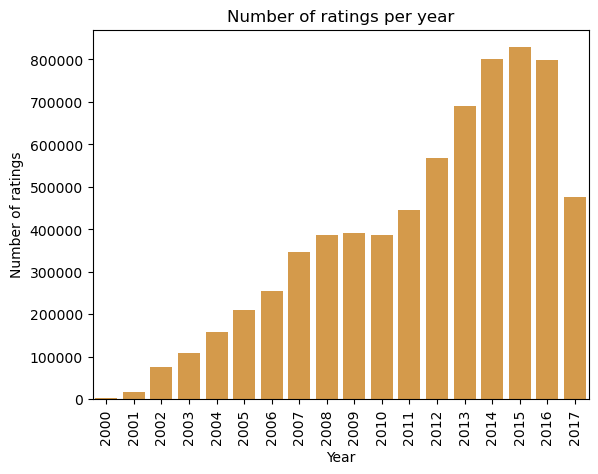

In [100]:
sns.countplot(RB_ratings_with_groups_and_users, x=RB_ratings_with_groups_and_users['date'].dt.year, color='#eb9e34')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Number of ratings')
plt.title('Number of ratings per year')
plt.show()

In [101]:
scipy.stats.pearsonr(RB_ratings_with_groups_and_users.groupby(RB_ratings_with_groups_and_users['date'].dt.year).size().values,
                     RB_users_validated.groupby(RB_users_validated['joined'].dt.year).size().values)

PearsonRResult(statistic=0.8388158497812095, pvalue=1.3634314892037081e-05)

There is strong positive correlation between number of user joining platform in given year and number of posted ratings.

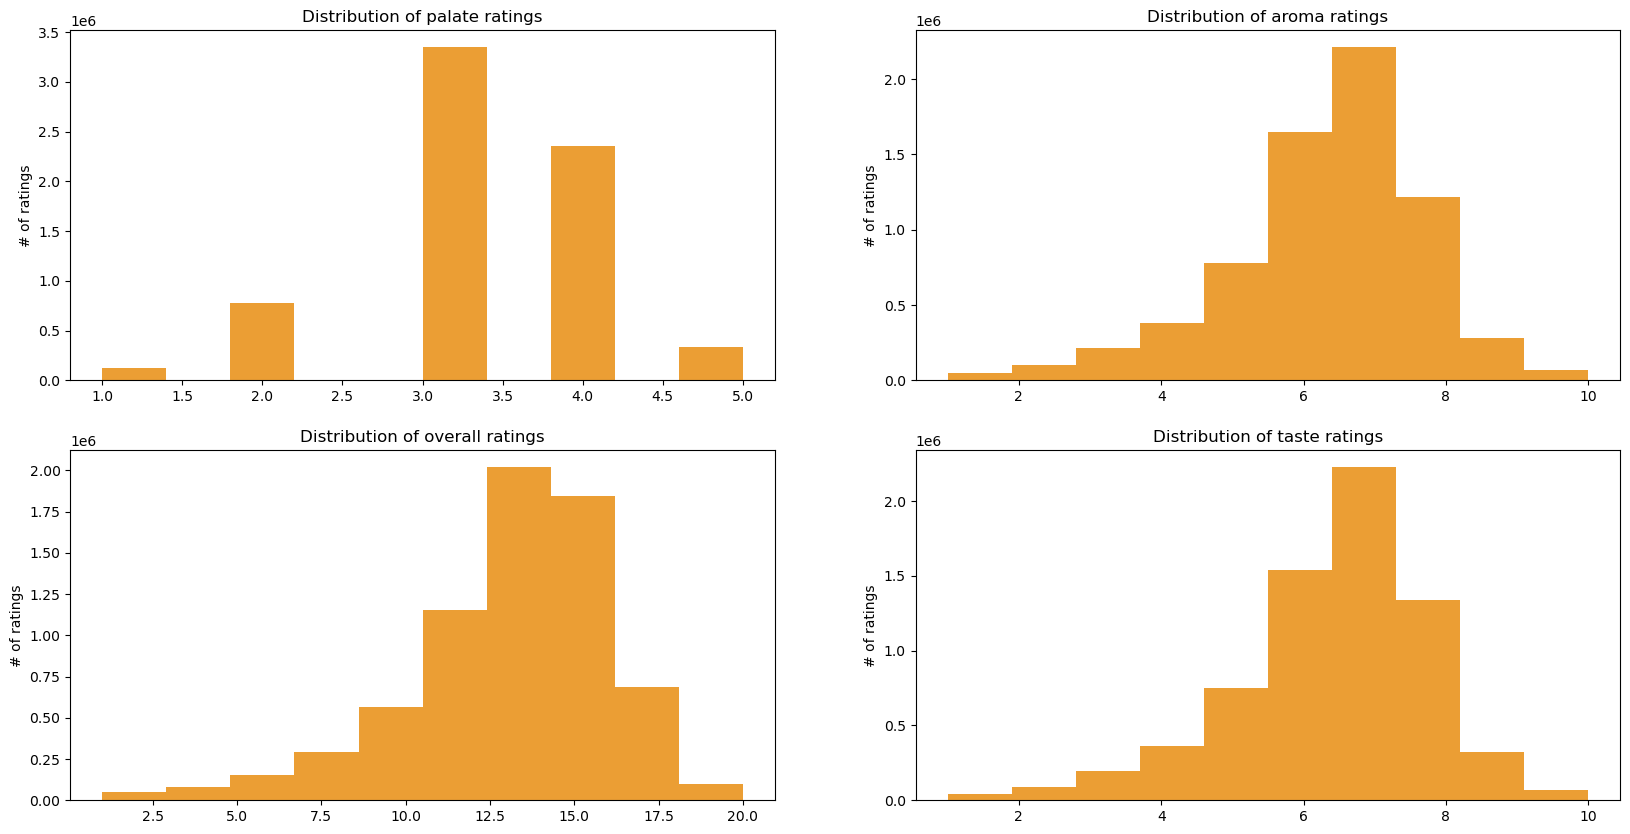

In [124]:
# plot distribution of different ratings aspects
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(2, 2, 1)
plt.hist(RB_ratings_with_groups_and_users['palate'], color='#eb9e34')
plt.ylabel('# of ratings')
plt.title('Distribution of palate ratings')
plt.subplot(2, 2, 2)
plt.hist(RB_ratings_with_groups_and_users['aroma'], color='#eb9e34')
plt.ylabel('# of ratings')
plt.title('Distribution of aroma ratings')
plt.subplot(2, 2, 3)
plt.hist(RB_ratings_with_groups_and_users['overall'], color='#eb9e34')
plt.ylabel('# of ratings')
plt.title('Distribution of overall ratings')
plt.subplot(2, 2, 4)
plt.hist(RB_ratings_with_groups_and_users['taste'], color='#eb9e34')
plt.ylabel('# of ratings')
plt.title('Distribution of taste ratings')
plt.show()


The distribution of each ratings are really similar

### 5. Initial analysis concerning research questions

In [41]:
# calculating statistics for AB InBev group through years
years_comparison = RB_group_breweries.groupby('year').nunique().loc[: , ['location', 'brewery_name']]

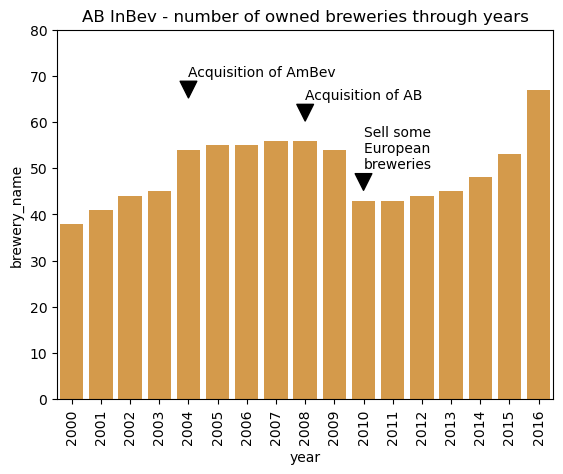

In [48]:
sns.barplot(data=years_comparison, x=years_comparison.index, y='brewery_name', color='#eb9e34')
plt.xticks(rotation=90)
plt.ylim(0, 80)
plt.title('AB InBev - number of owned breweries through years')
plt.annotate('Acquisition of AmBev', xy=(4, 65), xytext=(4, 70),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Acquisition of AB', xy=(8, 60), xytext=(8, 65),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Sell some \nEuropean \nbreweries', xy=(10, 45), xytext=(10, 50),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

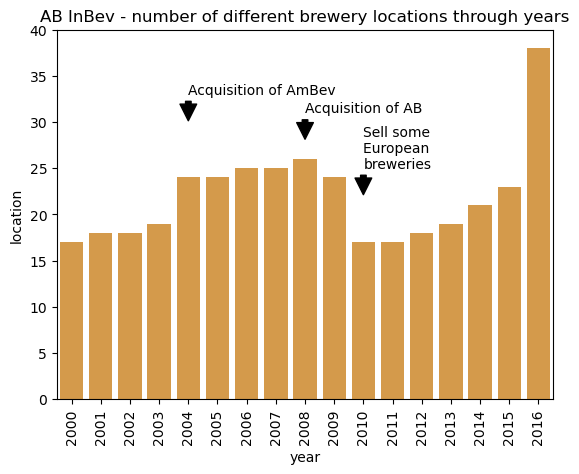

In [58]:
sns.barplot(data=years_comparison, x=years_comparison.index, y='location', color='#eb9e34')
plt.xticks(rotation=90)
plt.ylim(0, 40)
plt.title('AB InBev - number of different brewery locations through years')
plt.annotate('Acquisition of AmBev', xy=(4, 30), xytext=(4, 33),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Acquisition of AB', xy=(8, 28), xytext=(8, 31),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Sell some \nEuropean \nbreweries', xy=(10, 22), xytext=(10, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

In [94]:
InBev_ratings_per_year = RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['group'] == 'AB InBev'].groupby('year').size().to_frame().reset_index()
InBev_ratings_per_year = InBev_ratings_per_year.rename(columns={0: 'nbr_ratings'})
InBev_ratings_per_year['percentage'] = (InBev_ratings_per_year['nbr_ratings'] / RB_ratings_with_groups_and_users.groupby('year').size().values[:-1]) * 100
display(InBev_ratings_per_year)

,year,nbr_ratings,percentage
0,2000,60,2.408671
1,2001,716,4.047484
2,2002,2579,3.450490
3,2003,2703,2.500763
4,2004,4173,2.625883
5,2005,4814,2.295726
6,2006,5299,2.079638
7,2007,6528,1.883081
8,2008,12165,3.139809
9,2009,8791,2.248562


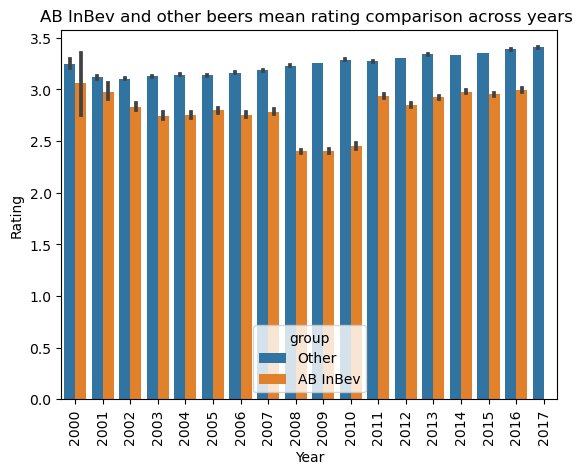

In [70]:
sns.barplot(RB_ratings_with_groups_and_users, x='year', y='rating', estimator='mean', hue='group')
plt.title('AB InBev and other beers mean rating comparison across years ')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

In [45]:
scipy.stats.ttest_ind(RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['group'] == 'AB InBev']['rating'], RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['group'] == 'Other']['rating'])

TtestResult(statistic=-260.42963609784897, pvalue=0.0, df=6946326.0)

The difference between means across all years are significant

In [126]:
goose_island_brewery = RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['brewery_name'] == 'Goose Island Beer Company &#40;AB-InBev&#41;']

The Gosse Island Brewery is a interested example of local brewery incorporated into AB InBev group in 2011, almost in the middle of our dataset range.  

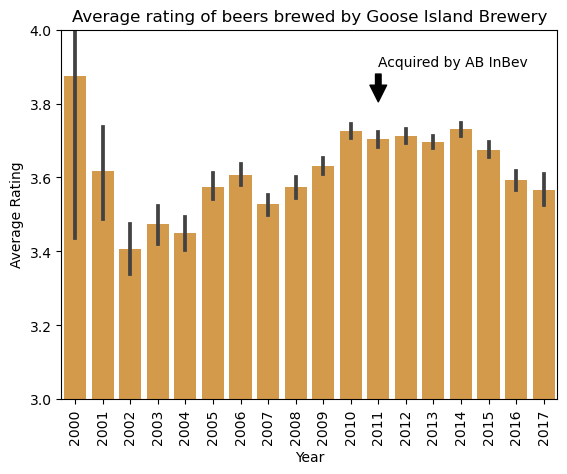

In [67]:
sns.barplot(goose_island_brewery, x='year', y='rating', color='#eb9e34')
plt.annotate('Acquired by AB InBev', xy=(11, 3.8), xytext=(11, 3.9),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title('Average rating of beers brewed by Goose Island Brewery')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.ylim(3.0, 4.0)
plt.xticks(rotation=90)
plt.show()

Although additional research should be conducted to eliminate impact of other covariants it it interesting to see  slightly but significant decrease in average rating in few years after acquisition.